In [1]:
from IPython.display import display
import numpy as np
# import modin.pandas as pd
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

plt.style.use("fivethirtyeight")
sns.set_style({'font.sans-serif': ['simsun', 'Arial']})
sns.set_style('darkgrid', {'font.sans-serif': ['simhei', 'Arial']})
%matplotlib inline

# np.random.seed(4590)
nf_data_path = r'../../Data/noFinacialFeatures.csv'
f_data_path = r'../../Data/FinacialFeatures.csv'

In [2]:
flevel = json.load(open(r'../FeatureEngineering/feature_level.json'))

In [3]:
nf_df = pd.read_csv(nf_data_path)
nf_df.head(5)

,企业编号,企业总评分,软著数量,作品著作数量,项目数量,纳税A级年份_2014,纳税A级年份_2015,纳税A级年份_2016,纳税A级年份_2017,资质证书数量,...,票面利率（%）_max,票面利率（%）_min,票面利率（%）_std,计划发行总额（亿元）_sum,计划发行总额（亿元）_max,计划发行总额（亿元）_min,计划发行总额（亿元）_std,城镇职工基本养老保险人数,保险实缴/人数,基数/人数
0,1001,75.374276,1.0,1.0,1.0,1.0,2.0,1.0,1.0,9.0,...,0.00,0.00,0.000000,0.0,0.0,0.0,0.000000,2176,17910.412479,43390.918022
1,1002,79.830122,2.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,...,4.35,3.05,0.712039,38.0,10.0,3.0,2.943920,2176,17910.412479,43390.918022
2,1003,78.318264,2.0,0.0,1.0,1.0,1.0,0.0,1.0,442.0,...,0.00,0.00,0.000000,0.0,0.0,0.0,0.000000,2176,17910.412479,43390.918022
3,1004,83.253376,0.0,6.0,1.0,0.0,0.0,2.0,1.0,1.0,...,5.50,3.88,0.580836,29.0,10.0,4.0,2.387467,2176,17910.412479,43390.918022
4,1005,83.291493,6.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,...,5.30,3.30,0.628865,70.0,10.0,3.0,2.943920,2176,17910.412479,43390.918022


In [4]:
f_df = pd.read_csv(f_data_path)
f_df.head(5)

,企业编号,企业总评分,资产:流动资产合计(元)_mean,资产:流动资产合计(元)_max,资产:流动资产合计(元)_min,资产:流动资产合计(元)_std,资产:流动资产合计(元)滚动增长_mean,资产:资产总计(元)_mean,资产:资产总计(元)_max,资产:资产总计(元)_min,...,应收账款周转天数(天)_mean,应收账款周转天数(天)_max,应收账款周转天数(天)_min,应收账款周转天数(天)_std,应收账款周转天数(天)滚动增长_mean,存货周转天数(天)_mean,存货周转天数(天)_max,存货周转天数(天)_min,存货周转天数(天)_std,存货周转天数(天)滚动增长_mean
0,1001,75.374276,37.138558,102.982866,-3.422013,45.402146,0.526979,5.236450,10.129814,0.418085,...,107.589270,191.707773,63.791689,44.495607,0.151392,414.778035,1089.655763,176.283983,325.371499,1.562757
1,1002,79.830122,53.649848,102.805115,-40.517576,70.738587,-0.250285,28.653568,44.691555,16.642118,...,46.903333,56.590000,39.830000,6.234116,0.023916,6.506667,7.040000,5.010000,0.702335,0.045330
2,1003,78.318264,-0.078404,23.757798,-18.510366,16.111779,-2.589393,-9.319352,15.939361,-24.609220,...,84.275556,139.910000,56.020000,33.143654,-0.040224,54.918889,75.540000,38.010000,11.089465,0.031792
3,1004,83.253376,43.189113,105.787782,1.316974,47.110533,15.573363,2.084637,7.893039,-2.714605,...,26.720000,35.360000,17.290000,6.024438,0.081857,6.954444,7.900000,6.240000,0.618448,0.021711
4,1005,83.291493,-8.351909,40.883944,-36.417633,32.154606,-0.489689,26.580415,34.378493,19.680974,...,94.050000,110.260000,77.850000,9.652235,0.012921,108.584444,357.190000,44.160000,101.728838,0.344086


In [5]:
df = pd.DataFrame()
df = nf_df.copy()
f_df.drop(['企业总评分'], axis=1, inplace=True)
df = df.merge(f_df, how='left', on='企业编号')
first_level = flevel['first_level']
first_level.append('企业编号')
first_level.append('企业总评分')
df = df[first_level]
df.head(5)

,资产:流动资产合计(元)_mean,资产:流动资产合计(元)_max,资产:流动资产合计(元)_min,资产:流动资产合计(元)_std,资产:流动资产合计(元)滚动增长_mean,资产:资产总计(元)_mean,资产:资产总计(元)_max,资产:资产总计(元)_min,资产:资产总计(元)_std,资产:资产总计(元)滚动增长_mean,...,票面利率（%）_max,票面利率（%）_min,计划发行总额（亿元）_sum,计划发行总额（亿元）_max,计划发行总额（亿元）_min,城镇职工基本养老保险人数,保险实缴/人数,基数/人数,企业编号,企业总评分
0,37.138558,102.982866,-3.422013,45.402146,0.526979,5.236450,10.129814,0.418085,3.678978,1.536082,...,0.00,0.00,0.0,0.0,0.0,2176,17910.412479,43390.918022,1001,75.374276
1,53.649848,102.805115,-40.517576,70.738587,-0.250285,28.653568,44.691555,16.642118,10.948562,-0.128498,...,4.35,3.05,38.0,10.0,3.0,2176,17910.412479,43390.918022,1002,79.830122
2,-0.078404,23.757798,-18.510366,16.111779,-2.589393,-9.319352,15.939361,-24.609220,17.478754,-0.527514,...,0.00,0.00,0.0,0.0,0.0,2176,17910.412479,43390.918022,1003,78.318264
3,43.189113,105.787782,1.316974,47.110533,15.573363,2.084637,7.893039,-2.714605,4.968071,-0.395071,...,5.50,3.88,29.0,10.0,4.0,2176,17910.412479,43390.918022,1004,83.253376
4,-8.351909,40.883944,-36.417633,32.154606,-0.489689,26.580415,34.378493,19.680974,5.327993,-0.055689,...,5.30,3.30,70.0,10.0,3.0,2176,17910.412479,43390.918022,1005,83.291493


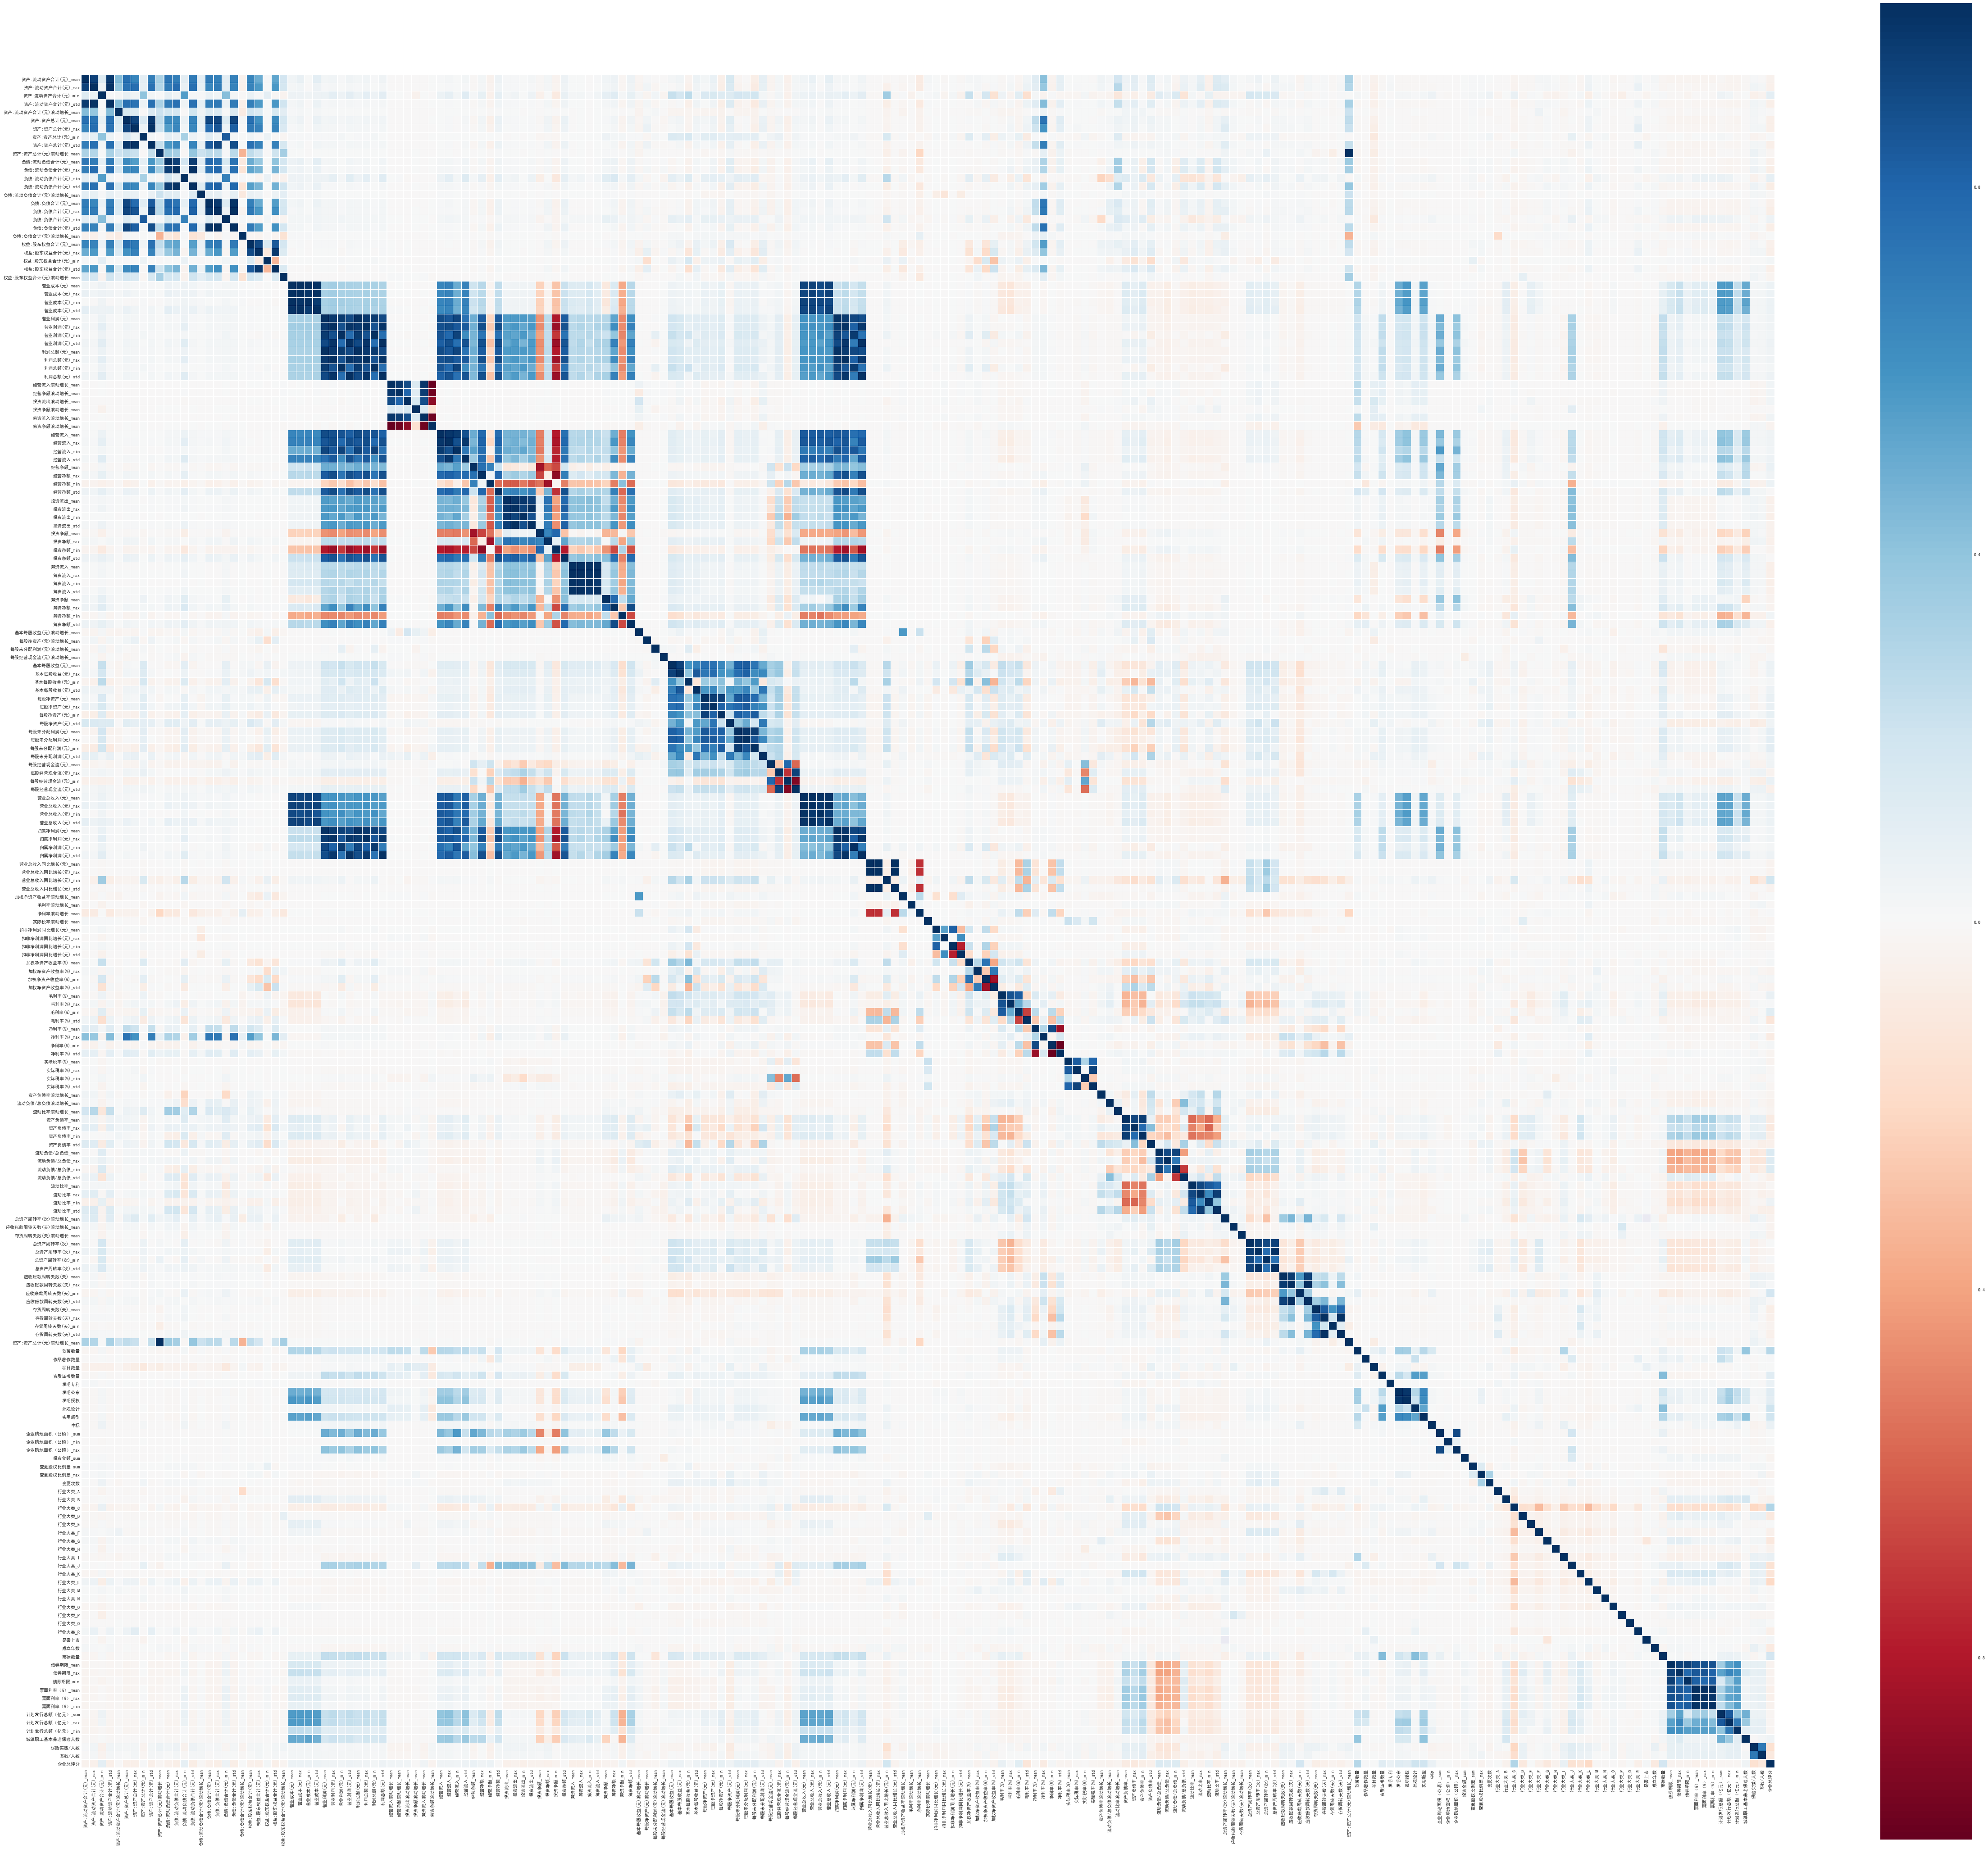

In [6]:
df_d = df.drop(['企业编号'], axis=1)
colormap = plt.cm.RdBu
plt.figure(figsize=(75, 75))
sns.heatmap(df_d.corr(),
            linewidths=0.1,
            vmax=1.0,
            square=True,
            cmap=colormap,
            linecolor='white',
            annot=False)

In [7]:
y = df[['企业编号', '企业总评分']]
x = df.drop(['企业总评分'], axis=1)

In [8]:
xtrain, xtest, ytrain, ytest = train_test_split(
    x, y, test_size=0.2, random_state=0)
ytrain_id = ytrain['企业编号']
ytrain = ytrain['企业总评分']
ytest_id = ytest['企业编号']
ytest = ytest['企业总评分']
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((2364, 205), (592, 205), (2364,), (592,))

In [9]:
xtrain.head(5)

,资产:流动资产合计(元)_mean,资产:流动资产合计(元)_max,资产:流动资产合计(元)_min,资产:流动资产合计(元)_std,资产:流动资产合计(元)滚动增长_mean,资产:资产总计(元)_mean,资产:资产总计(元)_max,资产:资产总计(元)_min,资产:资产总计(元)_std,资产:资产总计(元)滚动增长_mean,...,票面利率（%）_mean,票面利率（%）_max,票面利率（%）_min,计划发行总额（亿元）_sum,计划发行总额（亿元）_max,计划发行总额（亿元）_min,城镇职工基本养老保险人数,保险实缴/人数,基数/人数,企业编号
1547,862.893602,1729.699880,16.008621,925.115701,35.155613,597.737223,1247.127646,1.399889,647.371225,42.564189,...,0.00,0.00,0.00,0.0,0.0,0.0,2176,17910.412479,43390.918022,2574
119,9.744195,33.552321,0.165046,8.675827,1.051149,9.704551,22.736879,1.812185,5.227631,0.221645,...,4.18,4.18,4.18,4.0,2.0,2.0,5568,9852.891523,30941.091954,1121
2701,-5.603354,-2.039053,-11.103921,4.832681,0.800333,-5.406923,-2.025033,-10.750305,4.681685,0.779290,...,0.00,0.00,0.00,0.0,0.0,0.0,77,17232.936364,51970.753247,3745
1450,20.768775,57.200000,-24.416339,31.507471,0.284046,42.625216,74.200000,9.797959,26.477531,0.272086,...,0.00,0.00,0.00,0.0,0.0,0.0,85,16102.461412,54015.741176,2475
2400,-3.463861,-1.808249,-4.837535,1.293661,0.219700,-2.598305,-0.645321,-4.489817,1.282847,0.480873,...,0.00,0.00,0.00,0.0,0.0,0.0,1538,805.923277,6.301040,3441


In [10]:
id_train = xtrain['企业编号']
id_test = xtest['企业编号']
xtrain.drop(['企业编号'], axis=1, inplace=True)
xtest.drop(['企业编号'], axis=1, inplace=True)
xtrain.head(5)

,资产:流动资产合计(元)_mean,资产:流动资产合计(元)_max,资产:流动资产合计(元)_min,资产:流动资产合计(元)_std,资产:流动资产合计(元)滚动增长_mean,资产:资产总计(元)_mean,资产:资产总计(元)_max,资产:资产总计(元)_min,资产:资产总计(元)_std,资产:资产总计(元)滚动增长_mean,...,债券期限_min,票面利率（%）_mean,票面利率（%）_max,票面利率（%）_min,计划发行总额（亿元）_sum,计划发行总额（亿元）_max,计划发行总额（亿元）_min,城镇职工基本养老保险人数,保险实缴/人数,基数/人数
1547,862.893602,1729.699880,16.008621,925.115701,35.155613,597.737223,1247.127646,1.399889,647.371225,42.564189,...,0.0,0.00,0.00,0.00,0.0,0.0,0.0,2176,17910.412479,43390.918022
119,9.744195,33.552321,0.165046,8.675827,1.051149,9.704551,22.736879,1.812185,5.227631,0.221645,...,3.0,4.18,4.18,4.18,4.0,2.0,2.0,5568,9852.891523,30941.091954
2701,-5.603354,-2.039053,-11.103921,4.832681,0.800333,-5.406923,-2.025033,-10.750305,4.681685,0.779290,...,0.0,0.00,0.00,0.00,0.0,0.0,0.0,77,17232.936364,51970.753247
1450,20.768775,57.200000,-24.416339,31.507471,0.284046,42.625216,74.200000,9.797959,26.477531,0.272086,...,0.0,0.00,0.00,0.00,0.0,0.0,0.0,85,16102.461412,54015.741176
2400,-3.463861,-1.808249,-4.837535,1.293661,0.219700,-2.598305,-0.645321,-4.489817,1.282847,0.480873,...,0.0,0.00,0.00,0.00,0.0,0.0,0.0,1538,805.923277,6.301040


In [11]:
# sc_X = StandardScaler()
# xtrain = sc_X.fit_transform(xtrain)
# xtest = sc_X.transform(xtest)
# xtrain, xtest
# xtrain = (xtrain - xtrain.mean())/xtrain.std(ddof=0)
# xtest = (xtest - xtest.mean())/xtest.std(ddof=0)
# xtrain.head(5)

In [12]:
nfolds = 10
folds = KFold(n_splits=nfolds, shuffle=True, random_state=15)

In [13]:
param = {'num_leaves': 50,
         'min_data_in_leaf': 30,
         'objective': 'regression',
         'max_depth': 10,
         'learning_rate': 0.005,
         "min_child_samples": 100,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1}

In [14]:
feature_importance_df = np.zeros((xtrain.shape[1], nfolds))
mvalid = np.zeros(len(xtrain))
mfull = np.zeros(len(xtest))


for fold_, (trn_idx, val_idx) in enumerate(folds.split(xtrain.values, ytrain.values)):
    print('----')
    print("fold n°{}".format(fold_))

    x0, y0 = xtrain.iloc[trn_idx], ytrain.iloc[trn_idx]
    x1, y1 = xtrain.iloc[val_idx], ytrain.iloc[val_idx]

    trn_data = lgb.Dataset(x0, label=y0)
    val_data = lgb.Dataset(x1, label=y1)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets=[trn_data, val_data],
                    verbose_eval=500, early_stopping_rounds=150)
    mvalid[val_idx] = clf.predict(x1, num_iteration=clf.best_iteration)

    feature_importance_df[:, fold_] = clf.feature_importance()

    mfull += clf.predict(xtest,
                         num_iteration=clf.best_iteration) / folds.n_splits

----
fold n°0
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 2.17039	valid_1's rmse: 2.97385
Early stopping, best iteration is:
[730]	training's rmse: 1.81513	valid_1's rmse: 2.94918
----
fold n°1
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 2.14569	valid_1's rmse: 3.36549
Early stopping, best iteration is:
[745]	training's rmse: 1.77872	valid_1's rmse: 3.32353
----
fold n°2
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 2.16105	valid_1's rmse: 3.07415
Early stopping, best iteration is:
[811]	training's rmse: 1.72228	valid_1's rmse: 3.03546
----
fold n°3
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 2.15703	valid_1's rmse: 3.34838
[1000]	training's rmse: 1.53968	valid_1's rmse: 3.27099
Early stopping, best iteration is:
[1213]	training's rmse: 1.37225	valid_1's rmse: 3.26821
----
fold n°4
Training until validation scores don't im

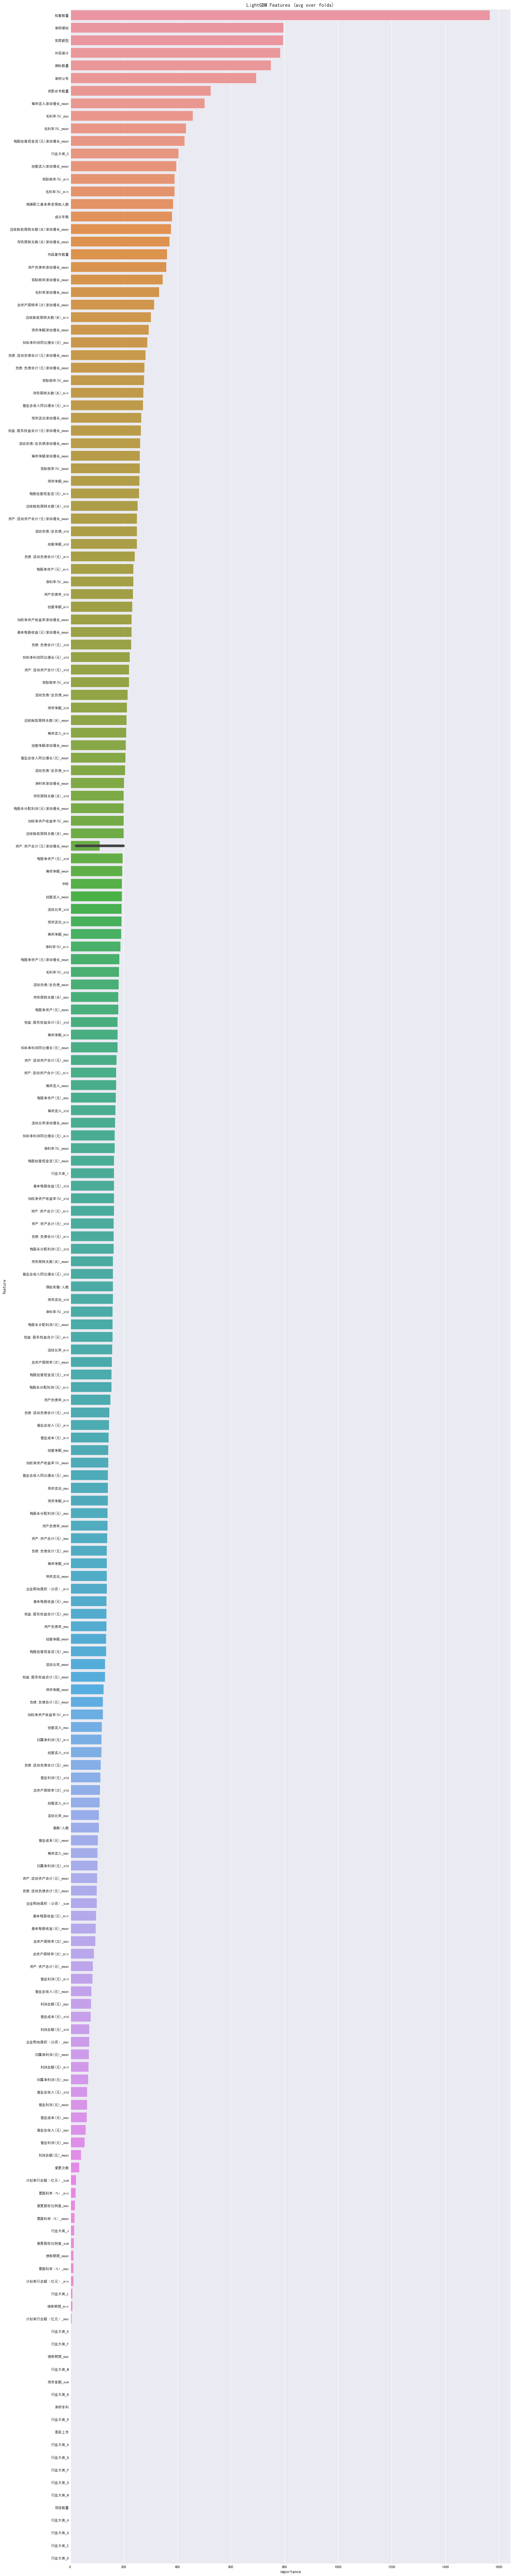

In [15]:
ximp = pd.DataFrame()
ximp['feature'] = xtrain.columns
ximp['importance'] = feature_importance_df.mean(axis=1)

plt.figure(figsize=(20, 100))
sns.barplot(x="importance",
            y="feature",
            data=ximp.sort_values(by="importance",
                                  ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [16]:
np.sqrt(mean_squared_error(mfull.astype(int), ytest.astype(int)))

3.013483214003536

In [ ]:
xsub = pd.DataFrame()
xsub['企业编号'] = id_test
xsub['企业总评分'] = mfull.astype(int)
xsub.to_csv('sub_lgb_scaling.csv', index=False)